In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import norm, pearsonr

import os
import time
import itertools

from glove_VI.glv3 import *

/home/jcthompson5@ad.wisc.edu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# import file names
files = os.listdir("data/SET3_Thirdtrial/")
files

['CDanc_CDmono12h_PROVIDET0.csv', 'CDevo_CDmono12h_PROVIDET0.csv']

# fit gLV models

In [3]:
exp_names = []
# for file in files:
file = files[1]
    
# define strain name
strain = file.split("_")[0]

# import data
df = pd.read_csv(f"data/SET3_Thirdtrial/{file}")
df.sort_values(by=["Treatments", "Time"], inplace=True)

# make sure that conditions have at least one measurement
dfs = []
for treatment, df_t in df.groupby("Treatments"):
    if df_t.shape[0] > 1:
        dfs.append(df_t)
df = pd.concat(dfs)

# determine species names 
species = df.columns.values[2:]

In [4]:
# init model 
model = gLV(dataframe=df, 
            species=species,
            nu2=.001, sigma2=.01)

# init params
model.init_params(sample=False)
print(f"Number of parameters: {model.n_params}")

# fit to data 
model.fit_posterior_EM()

Number of parameters: 240
Updating posterior...
Epoch 0, ELBO: -75341.430, Slope: 1.000
encountered 0 nans
Epoch 10, ELBO: -34024.355, Slope: 1.000
encountered 13 nans
Epoch 20, ELBO: -8756.065, Slope: 0.442
encountered 3 nans
Epoch 30, ELBO: -446.852, Slope: 0.332
encountered 0 nans
Epoch 40, ELBO: 2332.904, Slope: 0.251
encountered 0 nans
Epoch 50, ELBO: 2677.425, Slope: 0.192
encountered 0 nans
Epoch 60, ELBO: 5015.443, Slope: 0.154
encountered 1 nans
Epoch 70, ELBO: 10205.148, Slope: 0.131
encountered 1 nans
Epoch 80, ELBO: 13104.211, Slope: 0.114
encountered 2 nans
Epoch 90, ELBO: 13464.743, Slope: 0.100
encountered 2 nans
Epoch 100, ELBO: 13706.770, Slope: 0.121
encountered 0 nans
Epoch 110, ELBO: 13899.999, Slope: 0.172
encountered 0 nans
Epoch 120, ELBO: 14002.330, Slope: 0.127
encountered 0 nans
Epoch 130, ELBO: 14115.714, Slope: 0.103
encountered 0 nans
Epoch 140, ELBO: 14103.944, Slope: 0.081
encountered 0 nans
Epoch 150, ELBO: 14154.912, Slope: 0.050
encountered 0 nans
Epoc

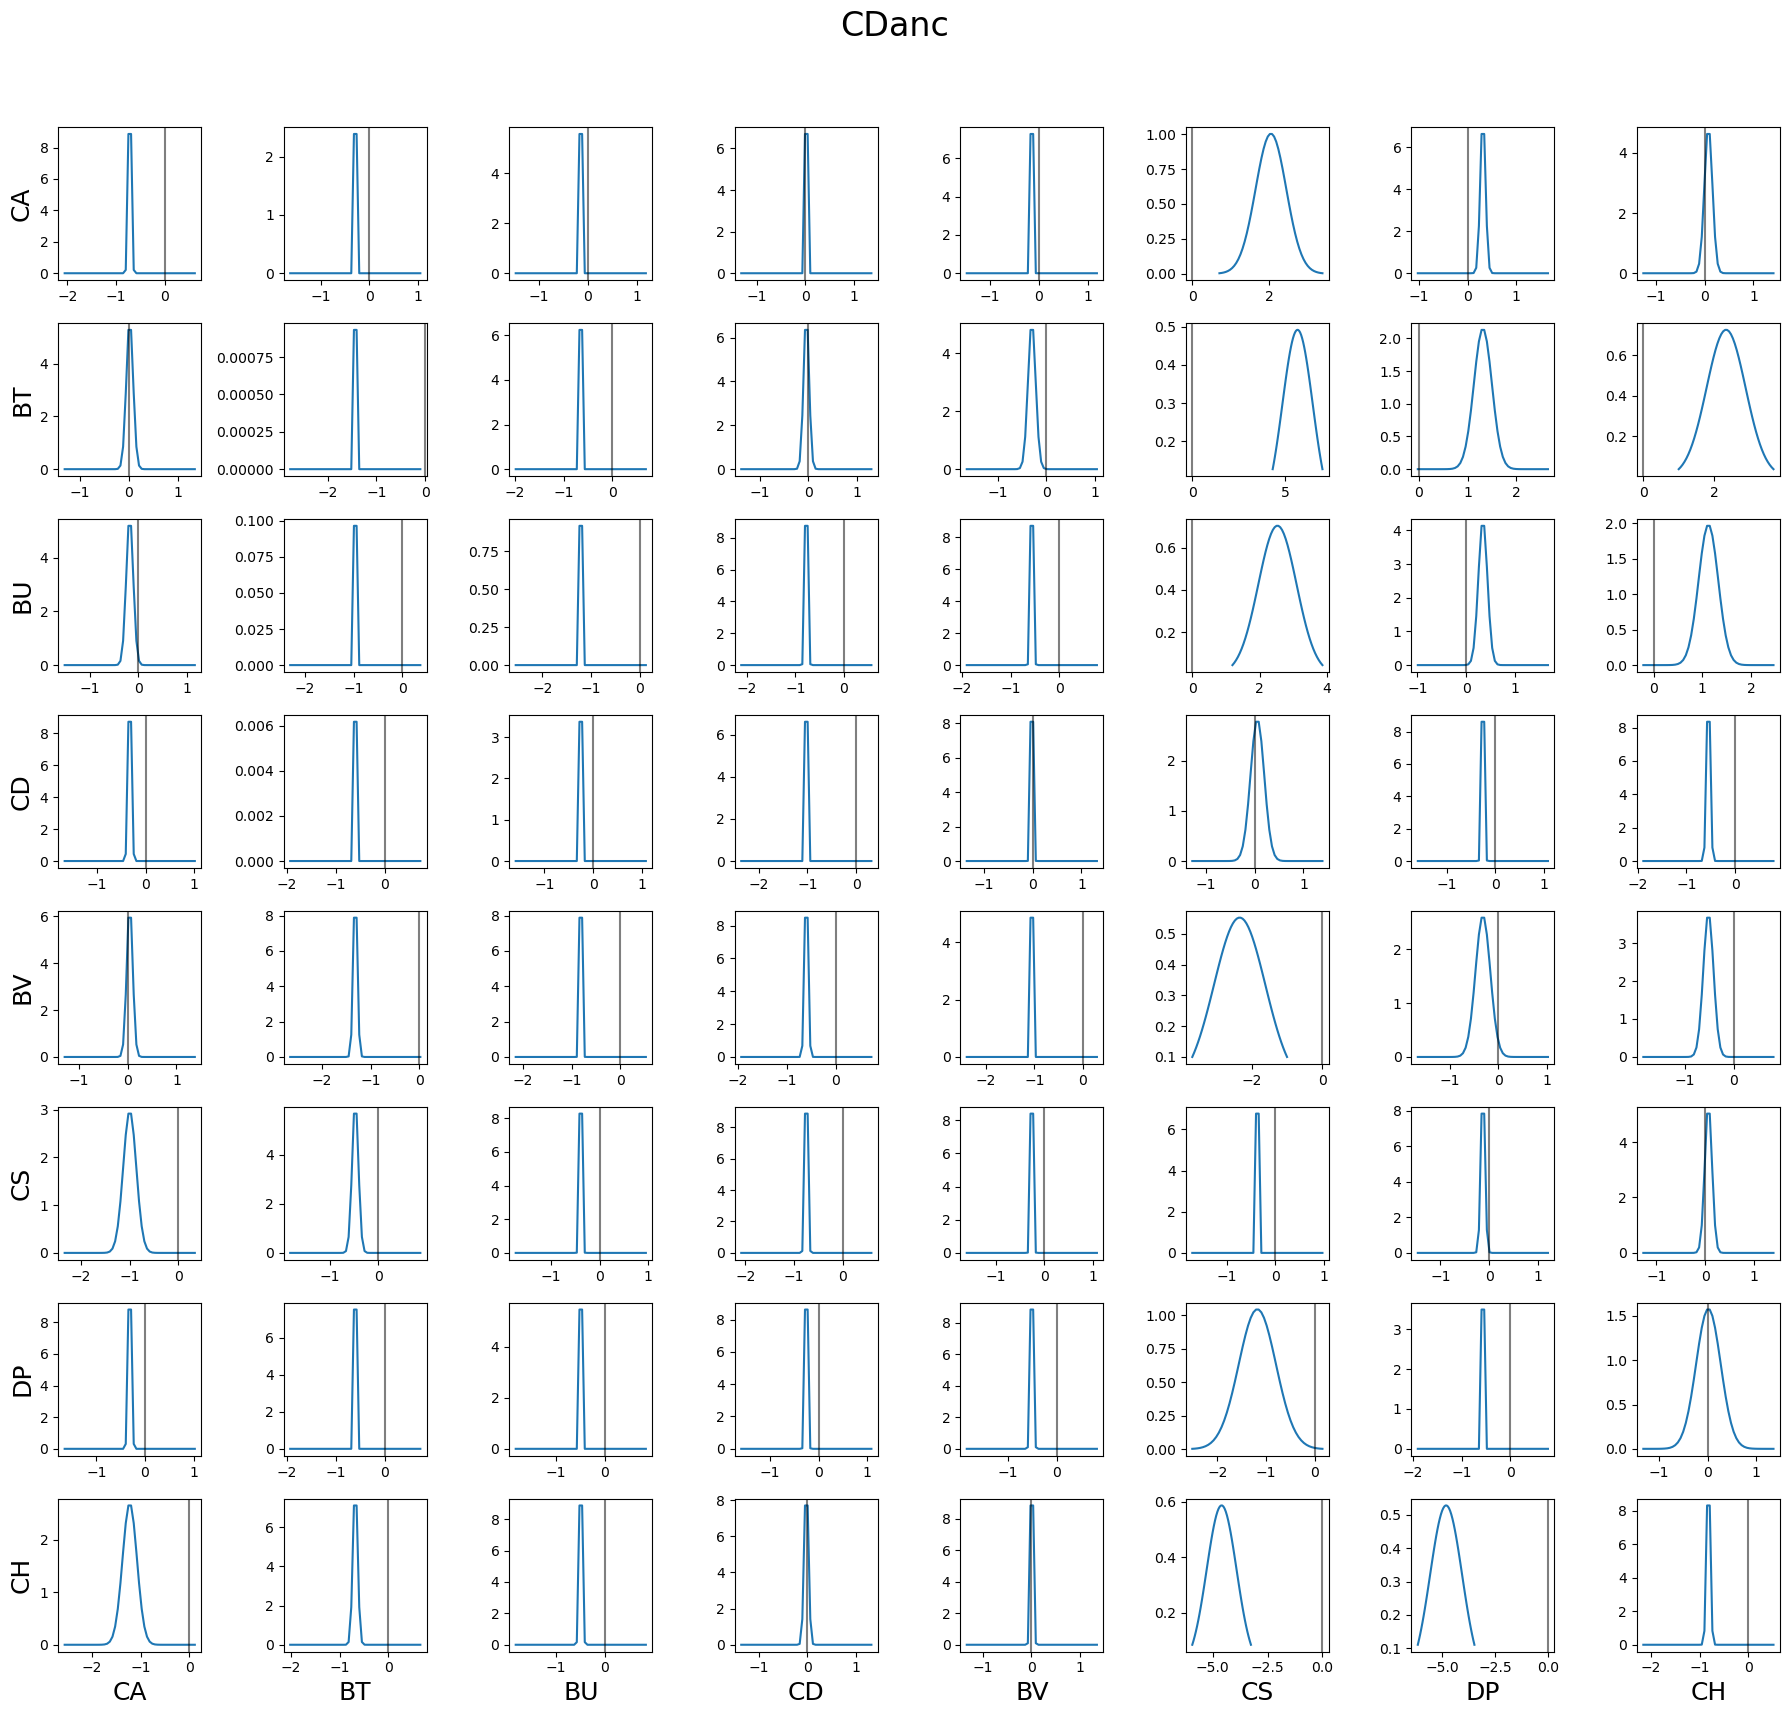

In [11]:
# plot parameter distribution
n_species = len(species)
Avec = model.z[n_species:n_species + n_species**2]
Aij_std = np.exp(model.lmbda[model.d:])[n_species:n_species + n_species**2]

plt.figure(figsize=(18,18))
# set counter for parameter std. 
k = 0

for i in range(n_species):
    for j in range(n_species):
        plt.subplot(n_species, n_species, k+1)
        a = np.linspace(Avec[k]-np.std(Avec), Avec[k]+np.std(Avec))
        plt.plot(a, norm.pdf(a,Avec[k],Aij_std[k]))
        plt.axvline(x=0, c='k', alpha=.5)
        k += 1
        if j == 0:
            plt.ylabel(species[i], fontsize=18)
        if i == n_species-1:
            plt.xlabel(species[j], fontsize=18)
        #plt.xlim([-2,2])

plt.suptitle(strain, fontsize=24)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig("params/SET3/"+strain+"_3.pdf")
plt.show()

# list of parameter names 
param_names2 = []
for s1 in species:
    for s2 in species:
        param_names2 += [s1+"*"+s2]

param_names3 = []
for i,s1 in enumerate(species):
    for j,s2 in enumerate(species):
        if j != i:
            for k,s3 in enumerate(species):
                if k > j and k !=i:
                    param_names3 += [s1+"*"+s2+"*"+s3]

param_names = list(species) + param_names2 + param_names3

# compute Wald test for each parameter
std_errors = np.exp(model.lmbda[model.d:])
walds = model.z/std_errors
wald_p_vals = 2*norm.cdf(-np.abs(walds))

# save to df 
df = pd.DataFrame()
df["Param name"] = param_names
df["Param value"] = model.z
df["Param stdv"]  = std_errors
df["Param p-value"] = wald_p_vals
df.to_csv("params/SET3/"+strain+"_3_VI.csv", index=False)

In [12]:
df

,Param name,Param value,Param stdv,Param p-value
0,CA,0.303748,0.004287,0.000000
1,BT,1.053222,0.003961,0.000000
2,BU,0.966207,0.003302,0.000000
3,CD,0.579588,0.002574,0.000000
4,BV,0.983519,0.007905,0.000000
...,...,...,...,...
235,CH*CD*CS,0.003902,1.015429,0.996934
236,CH*CD*DP,0.017561,1.028401,0.986376
237,CH*BV*CS,-0.020860,0.950433,0.982489
238,CH*BV*DP,-0.014462,0.989577,0.988340


In [13]:
hoi = []
for p_name in df['Param name'].values:
    
    if len(p_name.split("*")) == 3:
        hoi.append(True)
    else:
        hoi.append(False)
hoi = np.array(hoi)

In [15]:
p_vals = df.iloc[hoi]['Param p-value'].values

In [16]:
sum(p_vals < .05) / len(p_vals)

0.0